<a href="https://colab.research.google.com/github/hstrangis/7506R_2C2022_GRUPO4_N2/blob/main/7506R_TP2_GRUPO4_ENTREGA_N2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico 2: Propiedades en venta
# Grupo 4

### Integrantes
### 106963	- Matias Daniel Rueda
### 96407 - Nicolás Hernán Strangis
### 93525 - Miguel Centellas Leon

# Imports y setup

Importación e instalación de librerías y paquetes necesarios

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import numpy as np
import folium
import matplotlib
import joblib
import re

from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/datasets/df_test_post_preprocesamiento.csv")
df_train = pd.read_csv("/content/drive/MyDrive/datasets/df_train_post_preprocesamiento.csv")
df_original = pd.read_csv("/content/drive/MyDrive/datasets/properati_argentina_2021.csv")

In [ ]:
df_descrip = pd.read_csv("/content/drive/MyDrive/datasets/properati_argentina_2021_decrip.csv", engine='python', encoding='utf-8', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


#Procesamiento del lenguaje natural


##a) Ampliación del dataset

In [ ]:
df_descrip.head()

,id,property_description
0,BZCeiGkJr1WBUi6pKJQwJQ==,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...
1,zuHOGgUE0UB71W7m/YCLoA==,¡HERMOSO PH TIPO CASA DE 2 AMBIENTES!\nAPTO CR...
2,TUL813tXchVBlHUsfaA6DA==,Excelente PH en Núñez 4 amb!!!! Oportunidad !!...
3,gn55JPmcjftBV/at1a7fPg==,"UNICO PH DE 4 DORMITORIOS EN IMPECABLE ESTADO,..."
4,qg4m3QHcuo1+wMmyp7kx3Q==,Ph 2 Amb. Villa Crespo exclusivo uso profesion...


Eliminamos filas que contienen NaN del dataset de descripciones, para no tener problemas posteriormente al ejecutar ECMes

In [ ]:
df_descrip = df_descrip.dropna()

Verificamos que no hay descripciones vacias

In [ ]:
df_descrip.loc[df_descrip['property_description'].apply(type) != str].sum()

id                      0.0
property_description    0.0
dtype: float64

Quitamos caracteres que luego nos traeran problemas con ECMes

In [ ]:
df_descrip['property_description'] = df_descrip['property_description'].replace(['{','}','\[',']','\(','\)'],'', regex=True)
df_descrip['property_description'] = df_descrip['property_description'].replace('<br>','\n', regex=True)
df_descrip.head(10)

,id,property_description
0,BZCeiGkJr1WBUi6pKJQwJQ==,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...
1,zuHOGgUE0UB71W7m/YCLoA==,¡HERMOSO PH TIPO CASA DE 2 AMBIENTES!\nAPTO CR...
2,TUL813tXchVBlHUsfaA6DA==,Excelente PH en Núñez 4 amb!!!! Oportunidad !!...
3,gn55JPmcjftBV/at1a7fPg==,"UNICO PH DE 4 DORMITORIOS EN IMPECABLE ESTADO,..."
4,qg4m3QHcuo1+wMmyp7kx3Q==,Ph 2 Amb. Villa Crespo exclusivo uso profesion...
5,XztoBkv1vE+dGuId8GiPyA==,"Se Vende PH interno, ubicado en excelente barr..."
6,JEhUB1WqHYnvkmuPWlDgmg==,La propiedad se encuentra ubicada en Gobernado...
7,ucluEQ4sNKNVbwyKJFnaBw==,Casa en venta sobre calle Alejandro Magno con ...
8,a/LC2bANkFuEJYuHglYSTg==,Hermosa Casa en Ph ubicado a 10 cuadras del ce...
9,XWCMzAub+1YSpvBCuREdPA==,Hermosa casa en PH ubicada en barrio Santa Rit...


Generamos un archivo txt, que contiene las descripciones (solo 100, ya que sino demora muchisimo, fuimos tomando varias muestras aleatorias) sin nulos y sin caracteres que generen conflictos con las expresiones regulares

In [ ]:
with open("descripciones.txt", "w") as file_out:
  file_out.write('\n'.join(df_descrip['property_description'].head(100)))

Este archivo es procesado con ECMes localmente, obteniendo relaciones que nos permitieron extraer palabras claves para generar nuevas columnas de datos

Una vez analizados los resultados obtenidos, decidimos crear las siguientes columnas, utilizando como herramienta expresiones regulares, findall especificamente

Columna nueva, indica si el aviso posee pileta/piscina

In [ ]:
df_descrip['tiene_pileta'] = df_descrip['property_description'].str.findall('pileta | piscina', flags=re.IGNORECASE)
df_descrip['tiene_pileta'] = np.where(df_descrip['tiene_pileta'], 1, 0)

Columna nueva, indica si el aviso posee parrilla

In [ ]:
df_descrip['tiene_parrilla'] = df_descrip['property_description'].str.findall('parrilla', flags=re.IGNORECASE)
df_descrip['tiene_parrilla'] = np.where(df_descrip['tiene_parrilla'], 1, 0)

Columna nueva, indica si el aviso posee cochera

In [ ]:
df_descrip['tiene_cochera'] = df_descrip['property_description'].str.findall('cochera', flags=re.IGNORECASE)
df_descrip['tiene_cochera'] = np.where(df_descrip['tiene_cochera'], 1, 0)

Columna nueva, indica si el aviso posee terraza/balcón

In [ ]:
df_descrip['tiene_terraza'] = df_descrip['property_description'].str.findall('terraza|balcon', flags=re.IGNORECASE)
df_descrip['tiene_terraza'] = np.where(df_descrip['tiene_terraza'], 1, 0)

Columna nueva, indica si el aviso posee o no expensas, o si son bajas ('Sin expensas', 'Bajas expensas' o 'Con expensas')

Columna que identifica todos los avisos que contienen alguna descripcion vinculada a las expensas

In [ ]:
df_descrip['con_expensas'] = df_descrip['property_description'].str.findall('expensas | expensa', flags=re.IGNORECASE)
df_descrip['con_expensas'] = np.where((df_descrip['con_expensas'].str.len() != 0), 'Con expensas', '')

Luego creamos una columna que identifica los avisos con "Bajas" expensas

In [ ]:
df_descrip['bajas_expensas'] = df_descrip['property_description'].str.findall('bajas expensas|expensas bajas', flags=re.IGNORECASE)
df_descrip['bajas_expensas'] = np.where((df_descrip['bajas_expensas'].str.len() != 0), 'Bajas expensas', '')

Finalmente, una que contiene los avisos de lugares "Sin" expensas

In [ ]:
df_descrip['sin_expensas'] = df_descrip['property_description'].str.findall('sin expensas|expensas $0|expensas $ 0', flags=re.IGNORECASE)
df_descrip['sin_expensas'] = np.where((df_descrip['sin_expensas'].str.len() != 0), 'Sin expensas', '')

Por ultimo concatenamos las 3 nuevas columnas, y dejamos la celda vacia ('') en caso de que no se haga referencia a las expensas 

In [ ]:
df_descrip['expensas'] = df_descrip['bajas_expensas'] + df_descrip['sin_expensas']

# Se concatena solo en los casos donde hay '', ya que sino se sobreescribirian los demás valores
df_descrip['expensas'] = df_descrip[['expensas','con_expensas']].sum(axis=1).where(df_descrip['expensas'] == '', df_descrip['expensas'])

Eliminamos las columnas de expensas intermedias a la resultante 'expensas'

In [ ]:
df_descrip.drop(['con_expensas', 'sin_expensas', 'bajas_expensas'], axis = 'columns', inplace=True)
df_descrip.head(10)

,id,property_description,tiene_pileta,tiene_parrilla,tiene_cochera,tiene_terraza,expensas
0,BZCeiGkJr1WBUi6pKJQwJQ==,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...,0,0,0,1,Bajas expensas
1,zuHOGgUE0UB71W7m/YCLoA==,¡HERMOSO PH TIPO CASA DE 2 AMBIENTES!\nAPTO CR...,0,0,0,0,Sin expensas
2,TUL813tXchVBlHUsfaA6DA==,Excelente PH en Núñez 4 amb!!!! Oportunidad !!...,0,1,0,1,
3,gn55JPmcjftBV/at1a7fPg==,"UNICO PH DE 4 DORMITORIOS EN IMPECABLE ESTADO,...",0,0,1,1,Sin expensas
4,qg4m3QHcuo1+wMmyp7kx3Q==,Ph 2 Amb. Villa Crespo exclusivo uso profesion...,0,0,0,0,
5,XztoBkv1vE+dGuId8GiPyA==,"Se Vende PH interno, ubicado en excelente barr...",0,0,1,0,
6,JEhUB1WqHYnvkmuPWlDgmg==,La propiedad se encuentra ubicada en Gobernado...,1,0,1,0,
7,ucluEQ4sNKNVbwyKJFnaBw==,Casa en venta sobre calle Alejandro Magno con ...,1,0,1,0,
8,a/LC2bANkFuEJYuHglYSTg==,Hermosa Casa en Ph ubicado a 10 cuadras del ce...,0,0,0,1,
9,XWCMzAub+1YSpvBCuREdPA==,Hermosa casa en PH ubicada en barrio Santa Rit...,0,0,0,0,


Para agregar las columnas nuevas al df preprocesado, joineamos las columnas del dataset de descripciones usando como clave la columna 'id'

In [ ]:
df_ampliado_train = pd.merge(df_train, df_descrip[['tiene_cochera','tiene_parrilla','tiene_pileta','tiene_terraza','expensas','id']], on='id')
df_ampliado_test = pd.merge(df_test, df_descrip[['tiene_cochera','tiene_parrilla','tiene_pileta','tiene_terraza','expensas','id']], on='id')

# Borramos columna innecesaria
df_ampliado_train.drop(['Unnamed: 0'], axis = 'columns', inplace=True)
df_ampliado_test.drop(['Unnamed: 0'], axis = 'columns', inplace=True)
df_ampliado_train.head(100)

,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,id,tiene_cochera,tiene_parrilla,tiene_pileta,tiene_terraza,expensas
0,-34.566536,-58.479638,Capital Federal,Coghlan,Venta,Departamento,2.0,1.0,65.0,53.0,198000.0,USD,1 - Holmberg 2700,VZsvT1lQEuvPqEM4cjT8/g==,1,1,1,1,
1,-34.645625,-58.459408,Capital Federal,Flores,Venta,Departamento,1.0,1.0,29.0,29.0,63000.0,USD,Departamento a estrenar - Edificio con ameniti...,QlFGJ8qbIENvmMXqW4JbsQ==,0,1,1,0,
2,-34.592408,-58.454732,Capital Federal,Caballito,Venta,Departamento,2.0,1.0,41.0,35.0,93000.0,USD,Departamento de 2 ambientes con balcón aterraz...,D9nGcyK9B6vsyeUvuT8qbQ==,0,0,0,1,Con expensas
3,-34.577033,-58.423367,Capital Federal,Palermo,Venta,Departamento,1.0,1.0,49.0,44.0,160000.0,USD,Departamento - Monoambiente - Palermo Nuevo - ...,FLCnXUUffcnknzXIH9pBCg==,0,1,1,1,
4,-34.580210,-58.412815,Capital Federal,Palermo,Venta,Departamento,1.0,2.0,115.1,78.0,290000.0,USD,Departamento en Palermo,U1B7lvnYtd4L18Ccb8mvhw==,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-34.592927,-58.443849,Capital Federal,Villa Crespo,Venta,Departamento,2.0,1.0,30.0,30.0,69900.0,USD,DARWIN 700 - T/SOL - Villa Crespo,CmzBSYbHVmyVPDKlI+MA7w==,0,0,0,0,
96,-34.543026,-58.473482,Capital Federal,Saavedra,Venta,Departamento,2.0,1.0,35.0,35.0,77000.0,USD,VENTA 2 AMBIENTES OPORTUNIDAD LUZ SAAVEDRA TER...,uV8HYBPZ40y2IQUm0zCoHw==,0,1,0,1,Con expensas
97,-34.604960,-58.448139,Capital Federal,Villa Crespo,Venta,PH,2.0,1.0,30.0,24.0,60000.0,USD,PH MUY LUMINOSO-2 AMB - PB - VILLA CRESPO,QTHzIXzZylNJSpu8yKIemw==,0,0,0,0,Con expensas
98,-34.596886,-58.403090,Capital Federal,Barrio Norte,Venta,Departamento,3.0,2.0,74.0,71.0,169000.0,USD,Departamento 3 ambientes con balcón A ESTRENAR...,pt4YRpYfASBQQXT3D9tBpw==,0,0,0,0,


##Guardamos el dataset ampliado

In [ ]:
df_ampliado_train.to_csv("df_ampliado_train.csv");
df_ampliado_test.to_csv("df_ampliado_test.csv");

##b) Modelos

Imports

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics

Utilizamos los x_train, y_train, x_test e y_test del TP1

In [ ]:
x_train_TP1 = pd.read_csv("/content/drive/MyDrive/datasets/x_train_regresion.csv")
y_train_regresion = pd.read_csv("/content/drive/MyDrive/datasets/y_train_regresion.csv")
x_test_TP1 = pd.read_csv("/content/drive/MyDrive/datasets/x_test_regresion.csv")
y_test_regresion = pd.read_csv("/content/drive/MyDrive/datasets/y_test_regresion.csv")


x_train_TP1.drop(["Unnamed: 0"], axis=1, inplace=True)
y_train_regresion.drop(["Unnamed: 0"], axis=1, inplace=True)
x_test_TP1.drop(["Unnamed: 0"], axis=1, inplace=True)
y_test_regresion.drop(["Unnamed: 0"], axis=1, inplace=True)

Eliminamos columnas del dataset que no utilizaremos

In [ ]:
df_ampliado_train.drop(["id"], axis=1, inplace=True)
df_ampliado_test.drop(["id"], axis=1, inplace=True)

Seleccionamos las columnas nuevas generadas en la primera parte, tanto para la parte de train y test

In [ ]:
nuevas_columnas_train = df_ampliado_train[["tiene_cochera","tiene_parrilla","tiene_pileta","tiene_terraza","expensas"]]
nuevas_columnas_test = df_ampliado_test[["tiene_cochera","tiene_parrilla","tiene_pileta","tiene_terraza", "expensas"]]

Agregamos las nuevas columnas a x_train y x_test

In [ ]:
x_train_regresion = pd.concat([x_train_TP1, nuevas_columnas_train], axis=1)
x_test_regresion = pd.concat([x_test_TP1, nuevas_columnas_test], axis=1)

**Guardamos los modelos de x_train, x_test, y_train e y_test que utilizaremos para los modelos de regresion**

In [ ]:
x_train_regresion.to_csv("x_train_regresion_TP2.csv");
y_train_regresion.to_csv("y_train_regresion_TP2.csv");
x_test_regresion.to_csv("x_test_regresion_TP2.csv");
y_test_regresion.to_csv("y_test_regresion_TP2.csv");

Utilizamos labelEncoder para tranformar la variable expensas en un variable numerica. A labelEncoder lo entrenamos y transformamos con la variable expensas de x_train, para luego aplicar solamente transform sobre expensas en x_test

In [ ]:
labelEncoder = LabelEncoder()
x_train_regresion['expensas'] = labelEncoder.fit_transform(x_train_regresion['expensas'].astype(str))

In [ ]:
x_test_regresion['expensas'] = labelEncoder.transform(x_test_regresion['expensas'].astype(str))

**Estandarizamos los valores y de esta forma aquello valores grandes no tendran un mayor peso en los algorimos futuros que vayamos a utilizar**

In [ ]:
scaler = StandardScaler() 
x_train_regresion = scaler.fit_transform(x_train_regresion)

Utilizamos el scaler ya entrenado con x_train para x_test

In [ ]:
x_test_regresion = scaler.transform(x_test_regresion)

###Mismos HiperParametros que el TP1

Utilizamos los mismos hiperparametros utilizados en el TP1

In [ ]:
xgbr_sin_optimizar = xgb.XGBRegressor(subsample = 1.0,objective ='reg:squarederror',min_child_weight= 1, max_depth= 5, learning_rate= 0.2, gamma= 0.1, eval_metric = "rmse", eta = 0.5)
xgbr_sin_optimizar.fit(x_train_regresion, y_train_regresion);

Aplicamos las mismas metricas que utilizamos en el TP1

In [ ]:
pred_train=xgbr_sin_optimizar.predict(x_train_regresion)
pred_test=xgbr_sin_optimizar.predict(x_test_regresion)

mse_train = metrics.mean_squared_error(y_train_regresion, pred_train)
mse_test = metrics.mean_squared_error(y_test_regresion, pred_test)
print(f"El error (mse) de train es: {mse_train}")
print(f"El error (mse) de test es: {mse_test}")


rmse_train = metrics.mean_squared_error(y_train_regresion, pred_train, squared=False)
rmse_test = metrics.mean_squared_error(y_test_regresion, pred_test, squared=False)
print(f"El error (rmse) de train es: {rmse_train}")
print(f"El error (rmse) de test es: {rmse_test}")

print(f"La diferencia del error es {rmse_test - rmse_train}");


score = xgbr_sin_optimizar.score(x_test_regresion, y_test_regresion)
print(f"Y el score de test es {score}")

La siguiente imagen son las metricas obtenidas en el TP1

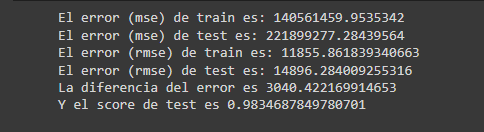

Como se puede ver las metricas son peores que las del TP1:
- El MSE de train y test en el TP1 son menores por lo tanto son mejores
- Lo mismo ocurre con las metricas obtenidas en RMSE, estas son mejores en el TP1
- El score obtenido en el TP1 es mejor que el obtenido en este nuevo modelo

**Guardamos el modelo NO optimizado**

In [ ]:
#Guadamos el modelo
joblib.dump(xgbr_sin_optimizar,"XGBoost_no_optimizado.pkl")

###Optimizamos los HiperParametros

Para optimizar los hiperparametros utilizaremos RandomizedSearchCV, para ahorrar tiempo en la busqueda de parametros

In [ ]:
#XGBoost regressor
xgbr = xgb.XGBRegressor()

#Parametros
parametros = {
    "max_depth": [3,4,5],
    "min_child_weight": [1,2,3],
    "gamma": [i/10.0 for i in range(2,5)],
    "learning_rate": [0.05, 0.1, 0.5],
    "objective":['reg:squarederror'],
    "subsample":[i/10.0 for i in range(2,5)],
    "eval_metric": ['rmse'],
    "eta": [i/10.0 for i in range(3,6)],

}

rand = RandomizedSearchCV(xgbr, param_distributions=parametros, cv = 5, n_iter = 10,random_state = 2)
rand.fit(x_train_regresion, y_train_regresion)
print(rand.best_params_)

In [ ]:
xgbr = xgb.XGBRegressor(subsample = 0.4,objective ='reg:squarederror',min_child_weight= 2, max_depth= 5, learning_rate= 0.5, gamma= 0.2, eval_metric = "rmse", eta = 0.3)
xgbr.fit(x_train_regresion, y_train_regresion);

In [ ]:
pred_train=xgbr.predict(x_train_regresion)
pred_test=xgbr.predict(x_test_regresion)

mse_train = metrics.mean_squared_error(y_train_regresion, pred_train)
mse_test = metrics.mean_squared_error(y_test_regresion, pred_test)
print(f"El error (mse) de train es: {mse_train}")
print(f"El error (mse) de test es: {mse_test}")


rmse_train = metrics.mean_squared_error(y_train_regresion, pred_train, squared=False)
rmse_test = metrics.mean_squared_error(y_test_regresion, pred_test, squared=False)
print(f"El error (rmse) de train es: {rmse_train}")
print(f"El error (rmse) de test es: {rmse_test}")

print(f"La diferencia del error es {rmse_test - rmse_train}");


score = xgbr.score(x_test_regresion, y_test_regresion)
print(f"Y el score de test es {score}")

Despues de optimizar los hiperparametros los resultados de las metricas mejoran por ejemplo:

- Las metrica mse obtenidas tanto para train y test en el TP1 son mas mayores a los obtenidos por este modelo 
- Y ademas el score obtenido es levemente mejor pasamode de un score 0.9834 a uno de 0.9844

**Guardamos el modelo optimizado**

In [ ]:
#Guadamos el modelo
joblib.dump(xgbr,"XGBoost_optimizado.pkl")

#Redes Neuronales

Imports

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 4.2 MB/s 
     |████████████████████████████████| 1.6 MB 31.4 MB/s 


In [ ]:
import keras_tuner as kt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

##Modelo Regresion

Los x_train, y_train , x_test e y_test que utilizaremos son los ya creados en el punto anterior

Creamos el modelo que utilizaremos para regresion

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(10,)))

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units,  activation = "relu"))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))

  model.add(keras.layers.Dense(1, kernel_initializer='normal', activation='relu'))

  hp_learning_rate = hp.Choice('learning_rate', values=[0.5, 1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss="mse",
                metrics=["mse"])

  return model

In [ ]:
tuner = kt.RandomSearch(model_builder,
                     objective='mse',
                     max_trials=5,
                     seed = 2)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=5)
tuner.search(x_train_regresion, y_train_regresion, epochs=500, batch_size=200, callbacks=[early_stopping], verbose=1)

Buscamos cual es la mejor epoca

In [ ]:
mejores_hiperParametros = tuner.get_best_hyperparameters(num_trials=1)[0]

modelo_armado = tuner.hypermodel.build(mejores_hiperParametros);

modelo_entrenado = modelo_armado.fit(x_train_regresion, y_train_regresion, epochs=150 , batch_size=200, callbacks=[early_stopping]);

valores_de_mse = modelo_entrenado.history['mse']

mejor_epoca = valores_de_mse.index(min(valores_de_mse)) + 1

print("La mejor epoca es:", mejor_epoca)

Epoch 1/150
316/316 [==============================] - 2s 6ms/step - loss: 40965091328.0000 - mse: 40965099520.0000
Epoch 2/150
316/316 [==============================] - 2s 5ms/step - loss: 19224113152.0000 - mse: 19224113152.0000
Epoch 3/150
316/316 [==============================] - 3s 9ms/step - loss: 8749960192.0000 - mse: 8749960192.0000
Epoch 4/150
316/316 [==============================] - 3s 10ms/step - loss: 7033888768.0000 - mse: 7033888768.0000
Epoch 5/150
316/316 [==============================] - 3s 9ms/step - loss: 5753716736.0000 - mse: 5753716736.0000
Epoch 6/150
316/316 [==============================] - 3s 9ms/step - loss: 4853275648.0000 - mse: 4853275648.0000
Epoch 7/150
316/316 [==============================] - 3s 8ms/step - loss: 4284427776.0000 - mse: 4284427776.0000
Epoch 8/150
316/316 [==============================] - 3s 10ms/step - loss: 3911116800.0000 - mse: 3911116800.0000
Epoch 9/150
316/316 [==============================] - 3s 9ms/step - loss: 3635193

Reentreno el modelo (Por ultima vez), pero esta vez con las mejores epocas

In [ ]:
modelo = tuner.hypermodel.build(mejores_hiperParametros)

modelo.fit(x_train_regresion, y_train_regresion, epochs=mejor_epoca ,batch_size=225 ,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/70
225/225 [==============================] - 3s 7ms/step - loss: 42855485440.0000 - mse: 42855485440.0000 - val_loss: 40191922176.0000 - val_mse: 40191922176.0000
Epoch 2/70
225/225 [==============================] - 2s 7ms/step - loss: 32512673792.0000 - mse: 32512673792.0000 - val_loss: 21813035008.0000 - val_mse: 21813035008.0000
Epoch 3/70
225/225 [==============================] - 2s 10ms/step - loss: 14387458048.0000 - mse: 14387458048.0000 - val_loss: 9874317312.0000 - val_mse: 9874317312.0000
Epoch 4/70
225/225 [==============================] - 2s 11ms/step - loss: 8879367168.0000 - mse: 8879367168.0000 - val_loss: 8150288384.0000 - val_mse: 8150288384.0000
Epoch 5/70
225/225 [==============================] - 2s 10ms/step - loss: 7610183168.0000 - mse: 7610183168.0000 - val_loss: 7084022272.0000 - val_mse: 7084022272.0000
Epoch 6/70
225/225 [==============================] - 2s 10ms/step - loss: 6614315008.0000 - mse: 6614315008.0000 - val_loss: 6143751680.0000 - val

In [ ]:
resultado = modelo.evaluate(x_test_regresion, y_test_regresion)
print("El valor de mse en test es : ", resultado[1])

535/535 [==============================] - 1s 2ms/step - loss: 6480001.5000 - mse: 6480001.5000
El valor de mse en test es :  6480001.5


In [ ]:
resultado = modelo.evaluate(x_train_regresion, y_train_regresion)
print("El valor de mse en train es : ", resultado[1])

1970/1970 [==============================] - 4s 2ms/step - loss: 6333602.5000 - mse: 6333602.5000
El valor de mse en train es :  6333602.5


In [ ]:
import joblib
#Guadamos el modelo
joblib.dump(modelo,"modelo_regresion.pkl")

['modelo_regresion.pkl']

##Modelo clasificación

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from tensorflow import keras

Cargamos los datasets que fueron usados en la clasificación del TP1

In [ ]:
df_ampliado_train = pd.read_csv("/content/drive/MyDrive/datasets/df_ampliado_train.csv")
df_ampliado_test = pd.read_csv("/content/drive/MyDrive/datasets/df_ampliado_test.csv")
y_train_clasif_orig = pd.read_csv("/content/drive/MyDrive/datasets/y_train_clasificacion.csv")
y_test_clasif_orig = pd.read_csv("/content/drive/MyDrive/datasets/y_test_clasificacion.csv")

Eliminamos columna innecesaria

In [ ]:
y_train_clasif_orig.drop(["Unnamed: 0"], axis=1, inplace=True)
y_test_clasif_orig.drop(["Unnamed: 0"], axis=1, inplace=True)

Dividimos el dataset ampliado para obtener el mismo tamaño que el target utilizado en el TP1

In [ ]:
x_train_clasif, x_test_clasif = train_test_split(df_ampliado_train, test_size = 0.20, random_state=2)

Dejamos los features que consideramos necesarios

In [ ]:
x_train_clasif = x_train_clasif[['latitud', 'longitud', 'property_rooms', 'property_surface_total','property_type']]
x_test_clasif = x_test_clasif[['latitud', 'longitud', 'property_rooms', 'property_surface_total','property_type']]

Hacemos Dummie encoding para la variable clasificatoria property_type

In [ ]:
x_train_clasif = pd.get_dummies(x_train_clasif, columns=['property_type'], drop_first=True)
x_test_clasif = pd.get_dummies(x_test_clasif, columns=['property_type'], drop_first=True)

**Guardamos los dataset que utilizaremos para train y test en la parte de clasificacion**

In [ ]:
x_train_clasif.to_csv("x_train_clasificacion_TP2.csv");
y_train_clasif_orig.to_csv("y_train_clasificacion_TP2.csv");
x_test_clasif.to_csv("x_test_clasificacion_TP2.csv");
y_test_clasif_orig.to_csv("y_test_clasificacion_TP2.csv");

Usamos OneHotEncoding para el target tipo_precio

In [ ]:
onehot = preprocessing.OneHotEncoder()
y_train_enco = onehot.fit_transform(y_train_clasif_orig).toarray()
y_test_enco = onehot.transform(y_test_clasif_orig).toarray()

**Estandarizamos los valores y de esta forma aquello valores grandes no tendran un mayor peso en los algorimos futuros que vayamos a utilizar**

In [ ]:
scaler = StandardScaler() 
x_train_scaled = scaler.fit_transform(x_train_clasif)

Utilizamos el scaler ya entrenado con x train para x_test

In [ ]:
x_test_scaled = scaler.transform(x_test_clasif)

### Creación del modelo de clasificación

Creamos un modelo de 3 capas, 10 entradas, la capa oculta y 3 salidas, ya que es la cantidad de clases que vamos a clasificar. Además el input shape serán la cantidad de variables con las que vamos a entrenar el modelo.
Luego de probar varios modelos e hiperparámetros, fue el mejor que encontramos, incluso utilizando KerasTuner (desarrollado más adelante)

In [ ]:
n_clases = 3
n_features_train = x_train_clasif.shape[1]

La activacion de la capa de salida será Softmax, ya que tenemos multiples clases en el target

In [ ]:
modelo_clasif = keras.Sequential([ 
    keras.layers.Dense(10,input_shape=(n_features_train,), activation='relu',kernel_initializer='uniform'),
    keras.layers.Dense(n_clases, activation='softmax')])

modelo_clasif.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                70        
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


Tomamos como optimizador SGD

In [ ]:
modelo_clasif.compile(
  optimizer = keras.optimizers.SGD(learning_rate = 0.001), 
  loss = 'categorical_crossentropy',
  metrics = ['accuracy'], 
)

Probamos con n_epocas épocas y n_batch de batch_size y entrenamos el modelo

In [ ]:
n_epocas = 50
n_batch = 15

modelo_clasif.fit(x_train_scaled, y_train_enco, epochs = n_epocas, batch_size = n_batch, verbose=False)

Predecimos el resultado con el modelo creado

In [ ]:
y_predic_clasif = modelo_clasif.predict(x_test_scaled)

394/394 [==============================] - 1s 1ms/step


Obtenemos los indices de los maximos

In [ ]:
y_predic_clasif_test = np.argmax(y_predic_clasif, axis=1).tolist()
y_real_clasif_test = np.argmax(y_test_enco, axis=1).tolist()

Obtenemos las metricas de test

In [ ]:
precision = precision_score(y_real_clasif_test, y_predic_clasif_test, average='weighted', zero_division = 0)
recall = recall_score(y_real_clasif_test, y_predic_clasif_test,average='weighted')
f1 = f1_score(y_real_clasif_test, y_predic_clasif_test, average='weighted')
print("Precision: " + str(precision));
print("Recall: " + str(recall));
print("F1 Score: " + str(f1));

Precision: 0.3367579599987106
Recall: 0.3364530456852792
F1 Score: 0.33633868095461766


Graficamos los resultados en una matriz de confusion

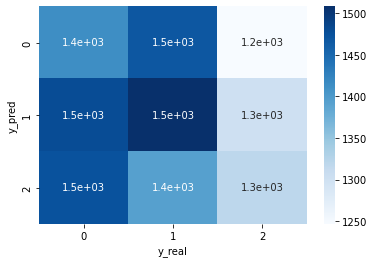

In [ ]:
ds_validacion_iris=pd.DataFrame(y_predic_clasif_test, y_real_clasif_test).reset_index()
ds_validacion_iris.columns=['y_pred','y_real']

tabla_iris=pd.crosstab(ds_validacion_iris.y_pred, ds_validacion_iris.y_real)
grf=sns.heatmap(tabla_iris, annot=True, cmap = 'Blues')
plt.show()

**Guardo el modelo**

In [ ]:
import joblib
#Guadamos el modelo
joblib.dump(modelo_clasif,"modelo_clasificacion.pkl")

['modelo_clasificacion.pkl']

Probamos con KerasTuner para ver si logramos mejores resultados

Idem al modelo de regresion, pero configuramos la ultima capa con Softmax

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(x_train_clasif.shape[1],)))

  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units,  activation = "relu"))
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
  model.add(keras.layers.Dense(3, kernel_initializer='normal', activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adagrad(learning_rate = hp_learning_rate),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

  return model

In [ ]:
tuner = kt.RandomSearch(model_builder,
                     objective="loss",
                     max_trials=5,
                     seed = 2)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(x_train_scaled, y_train_enco, epochs=20, batch_size=150, callbacks=[early_stopping], verbose=1)

Trial 5 Complete [00h 00m 32s]
loss: 1.098301649093628

Best loss So Far: 1.0977568626403809
Total elapsed time: 00h 03m 46s


Buscamos cual es la mejor epoca

In [ ]:
mejores_hiperParametros = tuner.get_best_hyperparameters(num_trials=1)[0]

modelo_armado = tuner.hypermodel.build(mejores_hiperParametros);

In [ ]:
modelo_armado = tuner.hypermodel.build(mejores_hiperParametros)

modelo_armado.fit(x_train_scaled, y_train_enco, epochs=100 ,batch_size=50 ,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
807/807 [==============================] - 4s 5ms/step - loss: 1.0991 - accuracy: 0.3303 - val_loss: 1.0991 - val_accuracy: 0.3386
Epoch 2/100
807/807 [==============================] - 4s 5ms/step - loss: 1.0985 - accuracy: 0.3440 - val_loss: 1.0990 - val_accuracy: 0.3319
Epoch 3/100
807/807 [==============================] - 4s 5ms/step - loss: 1.0983 - accuracy: 0.3430 - val_loss: 1.0991 - val_accuracy: 0.3288
Epoch 4/100
807/807 [==============================] - 4s 5ms/step - loss: 1.0982 - accuracy: 0.3414 - val_loss: 1.0992 - val_accuracy: 0.3311
Epoch 5/100
807/807 [==============================] - 3s 4ms/step - loss: 1.0981 - accuracy: 0.3432 - val_loss: 1.0991 - val_accuracy: 0.3346
Epoch 6/100
807/807 [==============================] - 3s 4ms/step - loss: 1.0979 - accuracy: 0.3454 - val_loss: 1.0991 - val_accuracy: 0.3346
Epoch 7/100
807/807 [==============================] - 4s 5ms/step - loss: 1.0979 - accuracy: 0.3449 - val_loss: 1.0991 - val_accuracy: 0.3309

In [ ]:
y_predic_clasif = modelo_armado.predict(x_test_scaled)

394/394 [==============================] - 1s 3ms/step


In [ ]:
y_predic_clasif_test = np.argmax(y_predic_clasif, axis=1).tolist()
y_real_clasif_test = np.argmax(y_test_enco, axis=1).tolist()

In [ ]:
precision = precision_score(y_real_clasif_test, y_predic_clasif_test, average='weighted', zero_division = 0)
recall = recall_score(y_real_clasif_test, y_predic_clasif_test,average='weighted')
f1 = f1_score(y_real_clasif_test, y_predic_clasif_test, average='weighted')
print("Precision: " + str(precision));
print("Recall: " + str(recall));
print("F1 Score: " + str(f1));


Precision: 0.33378223851345684
Recall: 0.3322493654822335
F1 Score: 0.32758358304279506


Las métricas obtenidas fueron similares al modelo seleccionado anteriormente

**Guardamos el modelo tuner**

In [ ]:
import joblib
#Guadamos el modelo
joblib.dump(modelo_armado,"modelo_clasificacion_tuner.pkl")

['modelo_clasificacion_tuner.pkl']

#Ensamble

##Stacking

Esta tecnica es procedimiento general para ensamblar modelos base a traves de entrenar un meta-modelo que tendra como objetivo encontrar una manera optima de combinar la salida de los modelos
individuales.

Usaremos los datasets de clasificacion del TP1

In [ ]:
x_train_st_TP1 = pd.read_csv("/content/drive/MyDrive/datasets/x_train_clasificacion.csv")
y_train_st_TP1 = pd.read_csv("/content/drive/MyDrive/datasets/y_train_clasificacion.csv")
x_test_st_TP1 = pd.read_csv("/content/drive/MyDrive/datasets/x_test_clasificacion.csv")
y_test = pd.read_csv("/content/drive/MyDrive/datasets/y_test_clasificacion.csv")


In [ ]:
x_train_st_TP1.columns

Index(['Unnamed: 0', 'latitud', 'longitud', 'property_rooms',
       'property_surface_total', 'property_surface_covered',
       'property_type_Departamento', 'property_type_PH'],
      dtype='object')

In [ ]:
x_train_st_TP1.columns.tolist()

['Unnamed: 0',
 'latitud',
 'longitud',
 'property_rooms',
 'property_surface_total',
 'property_surface_covered',
 'property_type_Departamento',
 'property_type_PH']

Eliminamos columnas innecesarias

In [ ]:
columnas_eliminar=['Unnamed: 0']
x_train_st_TP1.drop(columnas_eliminar, axis='columns', inplace=True)
x_train_st_TP1.columns.tolist()

y_train_st_TP1.drop(columnas_eliminar, axis='columns', inplace=True) 

In [ ]:
x_train_st_TP1.columns.tolist()

['latitud',
 'longitud',
 'property_rooms',
 'property_surface_total',
 'property_surface_covered',
 'property_type_Departamento',
 'property_type_PH']

In [ ]:
y_train_st_TP1.columns.tolist()

['tipo_precio']

Usaremos una funcion personalizada de evaluacion de modelos con 5 folds y 2 repeticiones

In [ ]:
def evaluate_model(model, x, y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')
    return scores

In [ ]:
#usaremos una Funcion personalizada para graficar performace del modelo
def graph_models(model_scores, name):
    
    m_name = list(model_scores.keys())
    results = [model_scores[model] for model in m_name]
    fig = go.Figure()
    for model, result in zip(m_name, results):
        fig.add_trace(go.Box(
            y=result,
            name=model,
            boxpoints='all',
            jitter=0.5,
            whiskerwidth=0.2,
            marker_size=2,
            line_width=1)
        )
    
    fig.update_layout(
    title='Performance de diferentes modelos seleccionados con 5-Fold Cross-Validation',
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=False)
    fig.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train_st_TP1, y_train_st_TP1, random_state = 42, train_size = 0.80)

Como modelos base, elegimos SVM, Knn y RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from collections import defaultdict
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

base_models = {'svm': SVC(),
               'knn': KNeighborsClassifier(n_neighbors=10),
               'random_forest':RandomForestClassifier(n_estimators=40)}
model_scores = defaultdict()
for name, model in base_models.items():
    print('Se evalua {}'.format(name))
    scores = evaluate_model(model, x_train, y_train)
    model_scores[name] = scores

Se evalua svm


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 18.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Se evalua knn


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Se evalua random_forest


[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.1s finished


Elegimos como metamodelo la Regresion Logistica

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]
meta_model = LogisticRegressionCV()
stacking_model = StackingClassifier(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

Con los datasets de entrenamiento, medimos performance del modelo

In [ ]:
stacking_scores = evaluate_model(stacking_model, x_train, y_train)
model_scores['stacking'] = stacking_scores

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed: 81.0min finished


Usamos la funcion para graficar la performance de los modelos base y el metamodelo

In [ ]:
import plotly.graph_objs as go
graph_models(model_scores, name='stacking_model_cv')

Se observa que el accuracy de Random Forest(tomando en cuanta los modelos individuales) es el de mejor valor.
y observando el ensamblado, dio casi igual, solo varia en una centesima( random forest=0.71 y stacking=0.72)

Entrenamos y posteriormente evaluamos en test

In [ ]:
from sklearn.metrics import accuracy_score
stacking_model.fit(x_train,y_train)
y_pred_st = stacking_model.predict(x_test)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  9.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent

In [ ]:
# Metricas 

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
DT_precision = precision_score(y_test, y_pred_st,average='weighted', zero_division = 0)
DT_recall = recall_score(y_test, y_pred_st,average='weighted')
print("Precision: " + str(DT_precision))
print("Recall: " + str(DT_recall))
print('F1-Score: {}'.format(f1_score(y_test, y_pred_st, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred_st)))

Precision: 0.7226409636361264
Recall: 0.7275726770108792
F1-Score: 0.7243889848436867
Accuracy: 0.7275726770108792


Comparativas:


Modelo de Clasificacion:
Precision: 0.3365608038785787
Recall: 0.33605647208121825
F1 Score: 0.2818827769486082

Stacking
Precision: 0.7226409636361264
Recall: 0.7275726770108792
F1-Score: 0.7243889848436867

Se aprecia claramente que las mejores metricas se obtiene desde la practica de Stacking y el modelo individual de Random Forest.

##Voting

En Voting se entrenan diferentes modelos con el mismo conjunto de datos y se selecciona la mejor predicción por un sistema de votación. Cada uno de los modelos entrenados emite su predicción en cada caso y la más votada será la seleccionada por el conjunto. Construiremos 3 modelos(Regresion Logistica, Random Forest y Knn) utilizando los mismos datos que se usaron en item anterior y y de alli se tomara la prediccion mayoritaria. A diferencia de Stacking, aca no usaremos metamodelo.

In [ ]:
x_voting=x_train_st_TP1.copy()
y_voting=y_train_st_TP1.copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

Spliteamos, entrenamos y evaluamos en test

In [ ]:
x_train_v, x_test_v, y_train_v, y_test_v = train_test_split(x_voting, y_voting, random_state = 42, train_size = 0.80)
vot_clf.fit(x_train_v, y_train_v)
pred_v = vot_clf.predict(x_test_v)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# Metricas 

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

DT_precision = precision_score(y_test, pred_v,average='weighted', zero_division = 0)
DT_recall = recall_score(y_test, pred_v,average='weighted')
print("Precision: " + str(DT_precision))
print("Recall: " + str(DT_recall))
print('F1-Score: {}'.format(f1_score(y_test, pred_v, average='weighted')))
print('Accuracy: {}'.format(accuracy_score(y_test_v, pred_v)))

Precision: 0.6524175189657023
Recall: 0.6248439450686641
F1-Score: 0.5945751052732463
Accuracy: 0.6248439450686641


Comparativas:

Modelo de Clasificacion:
Precision: 0.3365608038785787
Recall: 0.33605647208121825
F1 Score: 0.2818827769486082

Voting
Precision: 0.6524175189657023
Recall: 0.6248439450686641
F1-Score: 0.5945751052732463

Se observa que Voting dio mejor resultado por lo que se la puede considerar como una posible optimizacion.

# Conclusión

El trabajo para la obtención de nuevos datos utilizando procesamiento de lenguaje natural fue complejo dada la fuente de datos que teníamos. El manejo masivo de información de las descripciones requirió de un preprocesamiento, y al tener un texto con tantas alteraciones y poco uniforme llevó mucho tiempo de análisis.  

Los algoritmos de extracción de información necesitan de una entrada lo más limpia posible para funcionar correctamente. Éstos nos ayudaron a encontrar datos relevantes del dataset, los cuáles pudimos usar luego para añadir nuevos features. 

Los resultados en las métricas obtenidos al utilizar el modelo con las nuevas variables no cambiaron mucho respecto del TP1, algunas empeoraron y otras mejoraron levemente luego de optimizar los hiperparámetros (por ejemplo el score).

Respecto a las redes neuronales, obtuvimos mejores resultados en el modelo de regresión, midiendo el error cuadrático medio, utilizando las variables nuevas creadas.
En el modelo de clasificación optamos por definir el modelo mediante prueba y error, hasta que encontramos el que nos arrojó mejores metricas (siendo malas igualmente). 
Para intentar mejorarlo usamos KerasTuner para optimizar los hiperparámetros, pero las métricas obtenidas fueron similares. Utilizamos varios optimizadores pero el que mejor se adecuó a nuestro modelo fué SGD. 

Refiriéndonos a los modelos de ensamble, las métricas obtenidas en comparación a los modelos de clasificación del TP1 mejoraron notablemente, tanto en Stacking como Voting. Mejoramos en un 50% las métricas de precision, recall y f1_score.